## Conclusions and Visualizations

In this notebook we make conclusions from the numerical results of the experiments. We will also make some visualizations to help us understand the results better.

Contents:

- plot 1: x: min gain - max gain, y: fraction of pairs with gain smaller than x

- plot 2: average variance over all pairs over time

- average cycle length
 
- plot 3

In [285]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


In [286]:
sym_file = "BarcelonaFair.out"
analytical_file = "BarcelonaAnalytical.out"
with open(sym_file) as f:
    global data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    data = [line for line in lines if not line.startswith("Not enough routes ")]

with open(analytical_file) as f:
    global analytical_data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    analytical_data = [line for line in lines if not line.startswith("Not enough routes ")]

# create a pandas dataframe to store the data
data_dict = {}

# iterate over the lines - each od pair starts with a "Running simulation for" line
for i, line in enumerate(data):
    
    if not line.startswith("Running simulation for"):
        continue
        
    # get the origin and destination
    origin = line.split()[-2]
    destination = line.split()[-1]
    
    data_dict[(origin, destination)] = {}
    
    conv_line = data[i+1]
    data_dict[(origin, destination)]["convergence"] = -1
    if conv_line.startswith("Converged in"):
        # get the number of iterations
        data_dict[(origin, destination)]["convergence"] = int(conv_line.split()[-2])

    diff_line = data[i+2]
    data_dict[(origin, destination)]["difference"] = float(diff_line.split()[-1])
    
    mean_line = data[i+3]
    # array of mean values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", mean_line)

    
    if match:
        data_dict[(origin, destination)]["mean"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["mean"] = []
                
    variance_line = data[i+4]
    # array of variance values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", variance_line)

    
    if match:
        data_dict[(origin, destination)]["variance"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["variance"] = []
        
    hist_line = data[i+5]
    # array of arrays of integers
    match = re.search(r"\[\[([0-9.,\s\[\]]+)\]\]", hist_line)
    
    if match:
        data_dict[(origin, destination)]["history"] = [list(map(int, x.split(",")) ) for x in match.group(1).split("], [")]
    else:
        data_dict[(origin, destination)]["history"] = []
    
    # get number of agents
    agents_line = data[i+6]
    data_dict[(origin, destination)]["agents"] = round(float(agents_line.split()[-1]))

    # get fairness
    fairness_line = data[i+7]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", fairness_line)
    
    if match:
        data_dict[(origin, destination)]["fairness"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["fairness"] = []
        
    # get almost convergence
    almost_conv_line = data[i+8]

    match = re.search(r"\[([0-9.,\s]+)\]", almost_conv_line)
    
    if match:
        data_dict[(origin, destination)]["almost_convergence"] = list(map(int, match.group(1).split(",")))
    else:
        data_dict[(origin, destination)]["almost_convergence"] = []
        
    # get the standarized fairness
    
    standarized_fairness_line = data[i+9]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", standarized_fairness_line)
    
    if match:
        data_dict[(origin, destination)]["fairness_stand"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["fairness_stand"] = []
        
    data_dict[(origin, destination)]["min_fairness"] = min(data_dict[(origin, destination)]["fairness_stand"])
        
    data_dict[(origin, destination)]["min_fairness_at_5"] = min(data_dict[(origin, destination)]["fairness_stand"][:5])
    
    data_dict[(origin, destination)]["min_fairness_at_10"] = min(data_dict[(origin, destination)]["fairness_stand"][:10])
    
    data_dict[(origin, destination)]["min_fairness_at_50"] = min(data_dict[(origin, destination)]["fairness_stand"][:20])
# add the analytical data

for i, line in enumerate(analytical_data):
    if not line.startswith("OD pair"):
        continue
    origin, destination = line.split()[-1].split("-")
    
    next_line = analytical_data[i+1]
    data_dict[(origin, destination)]["analytical"] = int(next_line.split()[-1])
    
    next_line = analytical_data[i+2]
    data_dict[(origin, destination)]["gcd_analytical"] = int(next_line.split()[-1])
    

In [287]:
# use the data_dict to create a pandas dataframe
df = pd.DataFrame(data_dict).T
# add a column for the OD pair
df["OD"] = df.index
df["OD"] = df["OD"].apply(lambda x: " -> ".join(x))

#

In [288]:
# number of cases where convergence is equal to analytical
print("Convergence equal to analytical: ", len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is equal to gcd analytical and smaller than analytical
print("Convergence equal to gcd analytical while opting works: ", (len(df[df["convergence"] == df["gcd_analytical"]] )) - len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is less than gcd analytical
print("Convergence less than gcd analytical: ", (len(df[df["convergence"] < df["gcd_analytical"]]) - len(df[df["convergence"] == -1])))
# number of cases where convergence is greater than analytical
print("Convergence greater than analytical: ", len(df[df["convergence"] > df["analytical"]]))

# reshape almost convergence to multiple columns
for i in range(df["almost_convergence"].apply(len).max()):
    df["almost_convergence_" + str(i)] = df["almost_convergence"].apply(lambda x: x[i] if i < len(x) else np.nan)
    
for i in range(df["almost_convergence"].apply(len).max()):
    print("Convergence greater than almost convergence ${i}$: ", len(df[df["convergence"] > df["almost_convergence_" + str(i)] ]))

Convergence equal to analytical:  792
Convergence equal to gcd analytical while opting works:  564
Convergence less than gcd analytical:  5
Convergence greater than analytical:  0
Convergence greater than almost convergence ${i}$:  1350
Convergence greater than almost convergence ${i}$:  983
Convergence greater than almost convergence ${i}$:  642


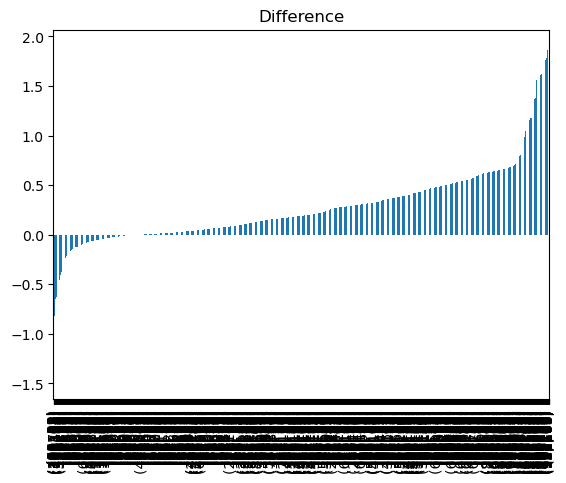

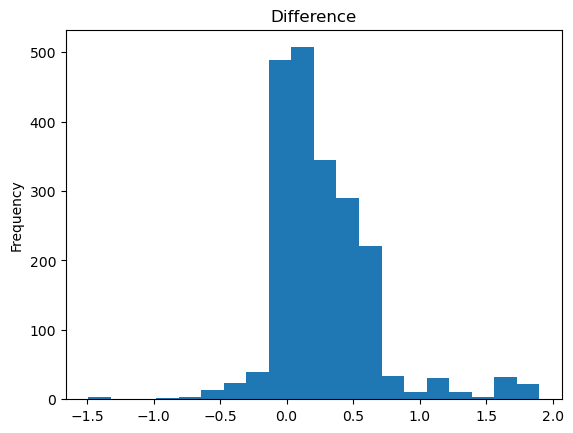

In [289]:
# create plots

# sort the df by the difference
df = df.sort_values(by="difference")

# plot the difference
plt.figure()
df["difference"].plot(kind="bar")
plt.title("Difference")
plt.show()

# create a histogram of the difference
plt.figure()
df["difference"].plot(kind="hist", bins=20)
plt.title("Difference")
plt.show()



In [290]:
# print percentage of negative differences
print("Percentage of negative differences: ", (df["difference"] < 0).sum() / len(df) * 100, "%")
# weighted percentage of negative differences
print("Weighted percentage of negative differences: ", (df["difference"] * df["agents"]).sum() / df["agents"].sum() * 100, "%")

Percentage of negative differences:  17.420596727622716 %
Weighted percentage of negative differences:  30.847264063660834 %


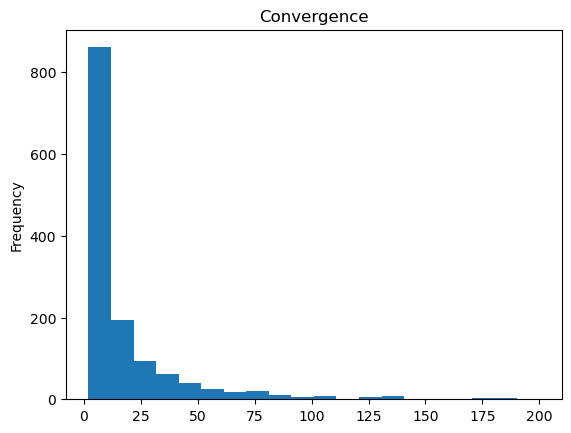

In [291]:
# lenght of the average cycle (convergence)
# filter out the pairs that did not converge
df2 = df[df["convergence"] != -1].copy()
plt.figure()
df2["convergence"].plot(kind="hist", bins=20)
plt.title("Convergence")
plt.show()


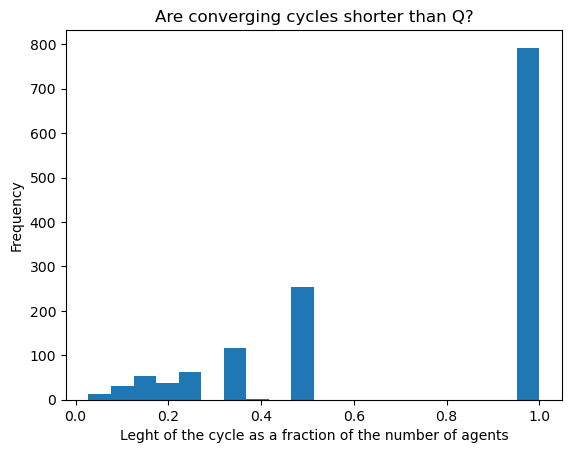

      convergence difference  \
41 3            2   0.046291   
   11           2       0.06   
   6            2    0.04011   
23 36           9   0.207648   
51 6            2   0.340958   
76 65           2   0.064646   
59 16           2   0.385268   

                                                    mean  \
41 3   [9.53, 19.06, 28.59, 38.12, 47.65, 57.18, 66.7...   
   11  [4.74, 9.48, 14.22, 18.96, 23.7, 28.44, 33.18,...   
   6   [5.4, 10.8, 16.200000000000003, 21.6, 27.0, 32...   
23 36  [4.276666666666667, 8.553333333333333, 12.83, ...   
51 6   [7.255, 14.51, 21.765, 29.02, 36.2750000000000...   
76 65  [12.69, 25.38, 38.07, 50.76, 63.45, 76.14, 88....   
59 16  [10.015000000000002, 20.030000000000005, 30.04...   

                                                variance  \
41 3   [9.999999999999574e-05, 0.0, 0.000100000000000...   
   11  [9.999999999999574e-05, 0.0, 9.999999999999574...   
   6   [0.00010000000000000463, 0.0, 9.99999999999957...   
23 36  [0.010888888888

In [292]:
# convergence/agents
plt.figure()
(df2["convergence"] / df2["agents"]).plot(kind="hist", bins=20)
plt.title("Are converging cycles shorter than Q?")
plt.xlabel("Leght of the cycle as a fraction of the number of agents")
plt.show()

# sort by this ratio and print head
df2["ratio"] = df2["convergence"] / df2["agents"]
df2 = df2.sort_values(by="ratio")
print(df2.head(7))
      

Text(0.5, 1.0, 'Average variance on OD pair over time')

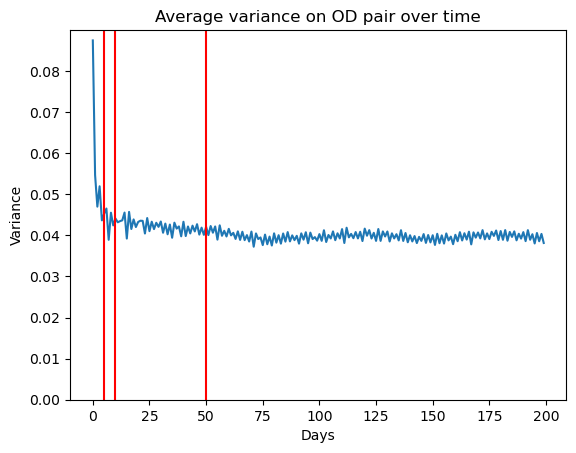

In [293]:
# analysis of non-converging cycles
# we need to aquire variance in 5, 10, 50 and 100 days
df3 = df[df["convergence"] == -1].copy()
# apart from variance calculate VMR, both mean and variance are arrays
df3['VMR'] = df3.apply(lambda row: [v/m for m, v in zip(row['mean'], row['variance'])], axis=1)
# variance is an array of variance over time
# plot average pair variance over time, add lines at 5, 10, 50 and 100 days

# calculate weighted variance - variaince multiplied by number of agents - should this be weighted at all?
df3["weighted_variance"] = df3["variance"].apply(lambda x: np.array(x) * df3["agents"].values[0])

avg_var = np.mean(df3['variance'].to_list(), axis=0) # average over all pairs, not agents!
plt.figure()
plt.plot(avg_var)
plt.ylim(ymin=0)
plt.axvline(x=5, color='r', label="5 days")
plt.axvline(x=10, color='r')
plt.axvline(x=50, color='r')
plt.xlabel("Days")
plt.ylabel("Variance")
plt.title("Average variance on OD pair over time")


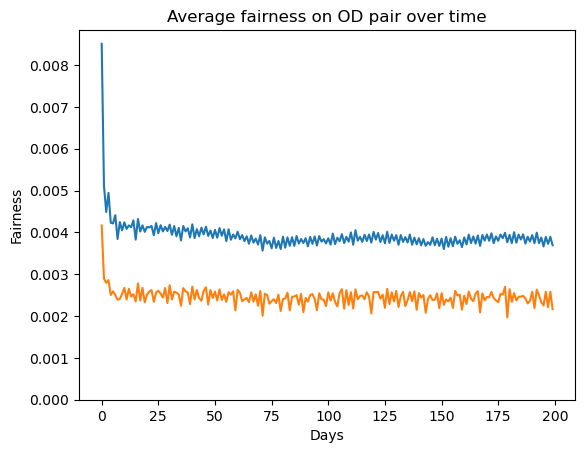

In [294]:
# plot average fairness for non-converging cycles with tolerance
avg_fairness = np.mean(df3['fairness'].to_list(), axis=0)
avg_fairness_all = np.mean(df['fairness'].to_list(), axis=0)

plt.figure()
plt.plot(avg_fairness)
plt.plot(avg_fairness_all)
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Fairness")
plt.title("Average fairness on OD pair over time")
plt.show()



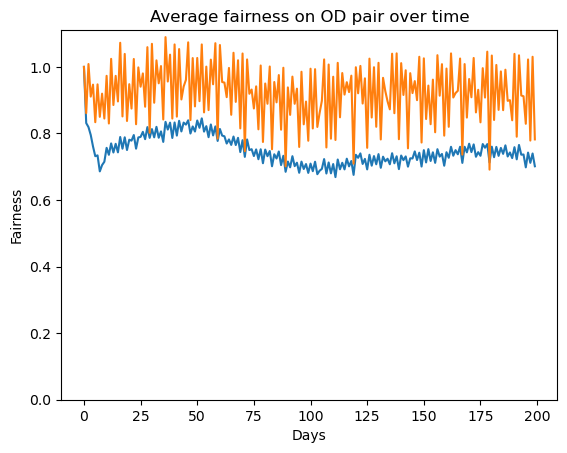

In [295]:
# plot standarized fairness for non-converging cycles with tolerance
avg_fairness = np.mean(df3['fairness_stand'].to_list(), axis=0)
avg_fairness_all = np.mean(df['fairness_stand'].to_list(), axis=0)

plt.figure()
plt.plot(avg_fairness)
plt.plot(avg_fairness_all)
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Fairness")
plt.title("Average fairness on OD pair over time")
plt.show()

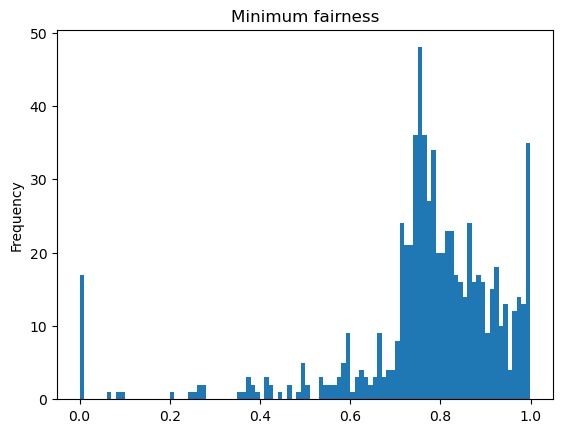

In [307]:
#histogram of the minimum fairness
df3["diff_min_fairness_10-total"] = df3["min_fairness_at_10"] - df3["min_fairness"]
df3["diff_min_fairness_5-total"] = df3["min_fairness_at_5"] - df3["min_fairness"]
df3["diff_min_fairness_50-total"] = df3["min_fairness_at_50"] - df3["min_fairness"]
df3["diff_fairness_min_starting"] = df3["fairness_stand"].apply(lambda x: x[0] - min(x))
plt.figure()

df3["diff_min_fairness_10-total"].plot(kind="hist", bins=100)
# df3["diff_min_fairness_5-total"].plot(kind="hist", bins=100)
# df3["diff_min_fairness_50-total"].plot(kind="hist", bins=100)
# df3["diff_fairness_min_starting"].plot(kind="hist", bins=100) # does this even make sense?
plt.title("Minimum fairness")   
plt.show()
